#  SignVision: Deep Neural Network for ASL Alphabet Recognition
**🔍 Building Intelligent Models to Understand Sign Language**

Welcome to SignVision, a deep learning-powered project focused on the automatic recognition of American Sign Language (ASL) alphabet signs using advanced computer vision techniques.

In a world that is rapidly embracing inclusive technologies, the ability to interpret sign language through AI not only bridges the communication gap between hearing and non-hearing individuals but also paves the way for accessible digital interactions.

**📌 Project Overview**

This notebook provides a complete walkthrough of a multi-class image classification task using both custom Convolutional Neural Networks (CNNs) and powerful Transfer Learning models. Here's what this project covers:

✅ Data Preparation: Load, label, and preprocess a dataset of ASL hand signs representing 29 classes.

✅ Custom CNN Model: Design and train a CNN from scratch to learn visual patterns in sign language.

✅ Transfer Learning Models:

VGG16

ResNet50V2

MobileNetV2

DenseNet201

✅ Evaluation Metrics: Compare models using accuracy, precision, recall, confusion matrix, and classification reports.

✅ Training Visualization: Plot performance trends to monitor overfitting and convergence.

**🎯 Objective**

To build, train, and evaluate multiple deep learning models capable of accurately classifying ASL alphabet images. This project highlights the performance differences between CNNs trained from scratch and pre-trained models fine-tuned for our specific task.

**🛠️ Tools & Technologies**

Python

TensorFlow / Keras

Matplotlib / Seaborn

Scikit-learn

# Importing Required Libraries

**In this section, we import all the necessary libraries for building, training, and evaluating a deep learning model for image classification**.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import shutil
from tensorflow import keras
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input as preprocess_densenet
from tensorflow.keras.utils import to_categorical

2025-05-08 01:44:53.939360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746668694.122508      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746668694.177149      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.__version__,cv2.__version__

('2.18.0', '4.11.0')

In [3]:
!python --version

Python 3.11.11


# Checking Available Devices

**Before training the neural network, it's helpful to check the available hardware resources (such as CPU or GPU). This ensures the model is utilizing the best available device for faster training.**

In [4]:
print('Available devices:')
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Load Dataset

**Listing Files and Folders in the Dataset**

**In this section, we inspect the folder structure where the images are stored.**

In [5]:
folder ='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

os.listdir(folder)

['N',
 'R',
 'space',
 'B',
 'I',
 'del',
 'F',
 'H',
 'E',
 'U',
 'M',
 'X',
 'K',
 'Q',
 'Y',
 'S',
 'G',
 'A',
 'O',
 'T',
 'V',
 'Z',
 'C',
 'P',
 'L',
 'W',
 'D',
 'nothing',
 'J']

In [6]:
os.path.join(folder, '0.jpg')

'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/0.jpg'

In [7]:
classes = os.listdir(folder)
print("Classes: ",classes)

Classes:  ['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


  0%|          | 0/16 [00:00<?, ?it/s]

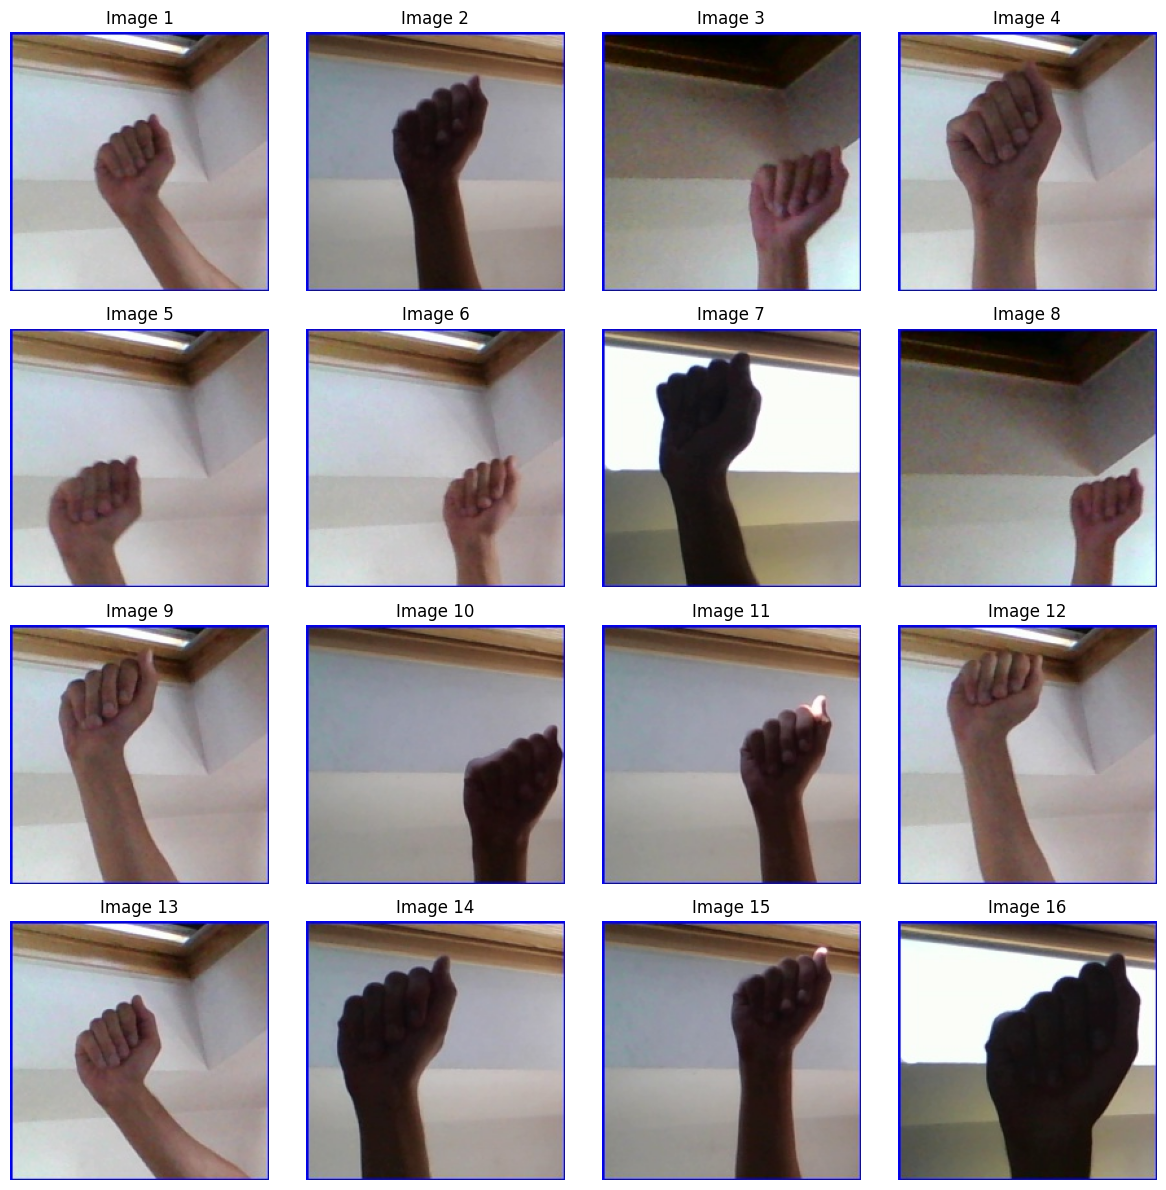

In [8]:
folder_show = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A'
# Get all image paths
images = []
for img in os.listdir(folder_show):
    if img.endswith(('.jpg', '.png', '.jpeg')):
        images.append(os.path.join(folder_show, img)) 

# Pick 16 random images
random_images = random.sample(images, 16)

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(tqdm(random_images)):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')
    
plt.tight_layout()
plt.show()

# Preparing Test Data

**In this step, we prepare the test data by following several key sub-steps:**

1. **Setting up paths**: We define the paths for the training and test datasets. Additionally, a temporary folder is created to store the test images.
2. **Copying test images**: All images from the test dataset are copied into a temporary folder for easier access.
3. **Handling the 'del' class**: A 'del' class image is randomly selected from the training dataset and added to the test set to ensure the model can recognize it during evaluation.
4. **DataFrame creation**: A pandas DataFrame is created to store the test images and their corresponding labels.
5. **Sampling test images**: We select a random sample of test images (with an adjustable size) to ensure we only use a portion of the data for testing.
6. **Class-to-index mapping**: We map class names to indices (from 0 to 28), ensuring consistency across training and testing.
7. **Preprocessing function**: Each image is resized to a fixed size (224x224) and normalized by dividing pixel values by 255 to scale them between 0 and 1.
8. **Loading and processing test images**: The test images are loaded, resized, and preprocessed. The labels are converted to their respective class indices.
9. **Verification**: We verify the dimensions of the processed test images and check the class index mapping to ensure everything is correct.
10. **One-hot encoding**: The test labels are converted to one-hot encoding format, which is required for classification tasks.

**This preparation ensures the data is ready for evaluation by the trained model.**


In [9]:
IMG_SIZE = 224
batch_size = 128
total_samples = 87000
train_split = 0.8
test_samples = 29  # 28 original + 1 del

# Paths
test_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
train_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
temp_test_path = '/kaggle/working/test_images/'



In [10]:
# Create temporary test directory
if os.path.exists(temp_test_path):
    shutil.rmtree(temp_test_path)
os.makedirs(temp_test_path)


In [11]:
#  Copy test images to temporary directory
test_file_paths = []
test_labels = []

for img_name in os.listdir(test_path):
    if img_name.lower().endswith('.jpg'):
        src_path = os.path.join(test_path, img_name)
        dst_path = os.path.join(temp_test_path, img_name)
        shutil.copy(src_path, dst_path)
        class_name = img_name.split('_')[0]
        test_file_paths.append(dst_path)
        test_labels.append(class_name)

In [12]:
# Copy one del image from training dataset
del_train_path = os.path.join(train_path, 'del')
del_images = [f for f in os.listdir(del_train_path) if f.lower().endswith('.jpg')]
if del_images:
    del_img_name = random.choice(del_images)
    src_del_path = os.path.join(del_train_path, del_img_name)
    dst_del_path = os.path.join(temp_test_path, 'del_test.jpg')
    shutil.copy(src_del_path, dst_del_path)
    test_file_paths.append(dst_del_path)
    test_labels.append('del')
else:
    print("No del images found in training dataset. Exiting.")
    exit()

# Create test DataFrame
test_df = pd.DataFrame({'filename': test_file_paths, 'class': test_labels})


In [13]:

#  Verify test dataset
print(f"Total test files found: {len(test_df)}")
print(f"Test classes: {sorted(set(test_labels))}")


Total test files found: 29
Test classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [14]:
# Adjust test_samples based on available data
test_samples = min(test_samples, len(test_df))
print(f"Adjusted test_samples to {test_samples} (available: {len(test_df)})")

Adjusted test_samples to 29 (available: 29)


In [15]:
# Randomly select test samples
if test_samples > 0:
    test_df = test_df.sample(n=test_samples, random_state=42).reset_index(drop=True)
else:
    print("No test samples available. Exiting.")
    test_images = np.array([])
    test_labels = np.array([])
    exit()

In [16]:

# Create class-to-index mapping (29 classes)
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
               'del', 'nothing', 'space']
class_to_index = {name: idx for idx, name in enumerate(class_names)}


In [17]:
# Define preprocessing function
def preprocess(x):
    return x / 255.0

In [18]:
# Load and preprocess test images
test_images = []
test_labels_indices = []

for _, row in tqdm(test_df.iterrows(), total=test_samples, desc="Loading test images"):
    # Load image
    img = cv2.imread(row['filename'])
    if img is None:
        print(f"Failed to load image: {row['filename']}")
        continue
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize to IMG_SIZE
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Preprocess
    img = preprocess(img)
    # Append to list
    test_images.append(img)
    test_labels_indices.append(class_to_index[row['class']])

# Convert to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels_indices)


Loading test images:   0%|          | 0/29 [00:00<?, ?it/s]

In [19]:

# Verify shapes and class indices
print(f"test_images shape: {test_images.shape}")
print(f"test_labels shape: {test_labels.shape}")
print(f"Class indices mapping: {class_to_index}")

test_images shape: (29, 224, 224, 3)
test_labels shape: (29,)
Class indices mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [20]:
# Convert test_labels to one-hot encoded format (29 classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=len(class_to_index))


# Preparing Training Data

In this section, we prepare the training dataset and validation dataset by following these steps:

1. **Collecting file paths and labels**: We iterate through the directories containing images for each class and store their file paths and corresponding labels.
2. **Creating the DataFrame**: We use pandas to create a DataFrame that contains the file paths and labels for each image, making it easier to handle the data.
3. **Random sampling**: We randomly select a predefined number of training samples (in this case, 87,000 samples) to train the model. This helps control the size of the dataset.
4. **Splitting into training and validation sets**: Using **train_test_split**, we divide the dataset into training and validation sets, ensuring that the class distribution is maintained (stratified).
5. **Preprocessing function**: The **preprocess** function normalizes the pixel values by dividing by 255, scaling them to the range [0, 1].
6. **Setting up ImageDataGenerator**: We use **ImageDataGenerator** from Keras to apply preprocessing transformations on the images during training and validation.
7. **Creating training and validation generators**: The **flow_from_dataframe** function is used to load images in batches and apply transformations automatically during training. This function generates data for the model to learn from.

**This setup ensures efficient data loading and augmentation for training.**

In [21]:
# Paths
train_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

# Collect training file paths and labels
file_paths = []
labels = []
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)

# Create training DataFrame
df = pd.DataFrame({'filename': file_paths, 'class': labels})

#  Randomly select 87,000 samples
df = df.sample(n=total_samples, random_state=42).reset_index(drop=True)

# Split into train and validation
train_df, val_df = train_test_split(df, train_size=train_split, stratify=df['class'], random_state=42)


#  Define preprocessing function
def preprocess(x):
    return x / 255.0

#  Set up ImageDataGenerator
cnn_datagen = ImageDataGenerator(
    preprocessing_function=preprocess
)

# Create training generator
cnn_train_generator = cnn_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

#  Create validation generator
cnn_val_generator = cnn_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create test generator

#  Check class indices
print("Training class indices:", cnn_train_generator.class_indices)
print("Validation class indices:", cnn_val_generator.class_indices)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.
Training class indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Validation class indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


# CNN Model

In this section, we define and train a Convolutional Neural Network (CNN) model for image classification using Keras. Below are the steps:

1. **Model Architecture**:
    - The model uses several **Convolutional (Conv2D)** layers to learn spatial features of the images.
    - Each Conv2D layer is followed by a **MaxPooling2D** layer to downsample the feature maps.
    - The model includes **Dropout** layers to reduce overfitting by randomly setting some neurons' output to zero during training.
    - The model ends with a **Dense** layer with a softmax activation function, which is suitable for multi-class classification (29 classes in total).

2. **Callbacks**:
    - **EarlyStopping**: Stops training if the validation loss does not improve for 5 consecutive epochs, and restores the best weights to avoid overfitting.
    - **ModelCheckpoint**: Saves the best model (based on validation loss) during training.

3. **Compilation**: 
    - The model uses the **Adam** optimizer and **Categorical Crossentropy** as the loss function, which is ideal for multi-class classification tasks. Additionally, we track accuracy, precision, and recall metrics.

4. **Model Training**:
    - The model is trained using the `fit` method, with training data from the `cnn_train_generator` and validation data from `cnn_val_generator`.
    - The training history is tracked, and the results (loss and accuracy) are plotted after training.

**The next step is visualizing the training progress with loss and accuracy plots.**

In [22]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=len(cnn_val_generator.class_indices), activation='softmax', dtype='float32')
])

I0000 00:00:1746669036.699797      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [23]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,317,149 (85.13 MB)

 Trainable params: 22,317,149 (85.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [25]:
cnn_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [26]:
cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 5,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/5


I0000 00:00:1746669058.755098      63 service.cc:148] XLA service 0x333d60c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746669058.755952      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746669059.147951      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746669069.770884      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.3540 - loss: 2.1812 - precision: 0.7131 - recall: 0.2489
Epoch 1: val_loss improved from inf to 0.23054, saving model to CNN_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.3545 - loss: 2.1795 - precision: 0.7134 - recall: 0.2494 - val_accuracy: 0.9234 - val_loss: 0.2305 - val_precision: 0.9466 - val_recall: 0.9024
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9278 - loss: 0.2094 - precision: 0.9444 - recall: 0.9127
Epoch 2: val_loss improved from 0.23054 to 0.13347, saving model to CNN_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 226s 412ms/step - accuracy: 0.9278 - loss: 0.2093 - precision: 0.9444 - recall: 0.9127 - val_accuracy: 0.9598 - val_loss: 0.1335 - val_precision: 0.9654 - val_recall: 0.9530
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9652 - loss: 0.1008 - precision: 0.9693 - recall: 0.9613
Epoch 3: val_loss improved from 0.13347 to 0.05374, saving mo

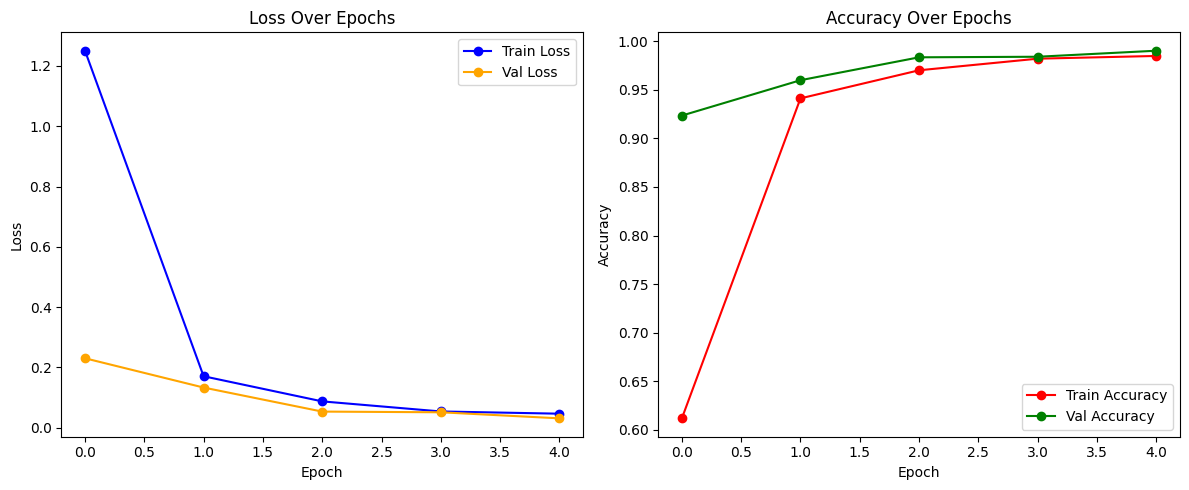

In [27]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluating and Predicting with the Best Model CNN

**Once the CNN model has been trained, we save the best-performing model using `model.save()` and then load it back using `load_model()`. This ensures we use the model with the lowest validation loss.**

In [28]:
cnn_model.save('CNN_best_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 7.7797e-04 - precision: 1.0000 - recall: 1.0000
Test Loss: 0.0008
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1

<Figure size 1000x800 with 0 Axes>

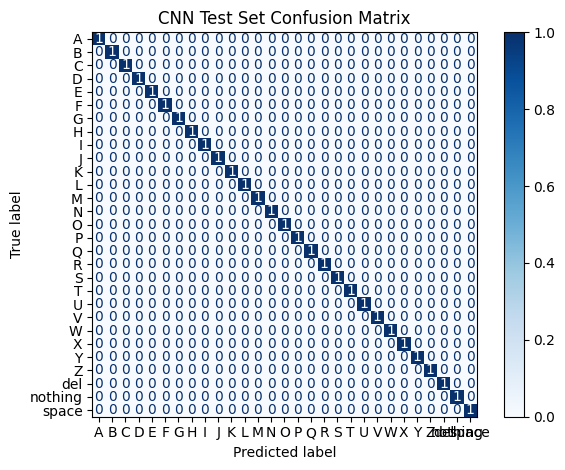

In [29]:
best_model=load_model('CNN_best_model.keras')


#  Evaluate the best model on test data
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    test_images, 
    test_labels_one_hot
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

#  Generate predictions with the best model
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels  # Use test_labels directly (class indices)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_index.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Test Set Confusion Matrix')
plt.tight_layout()


#  Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=list(class_to_index.keys()))
print("\nClassification Report:")
print(report)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/16 [00:00<?, ?it/s]

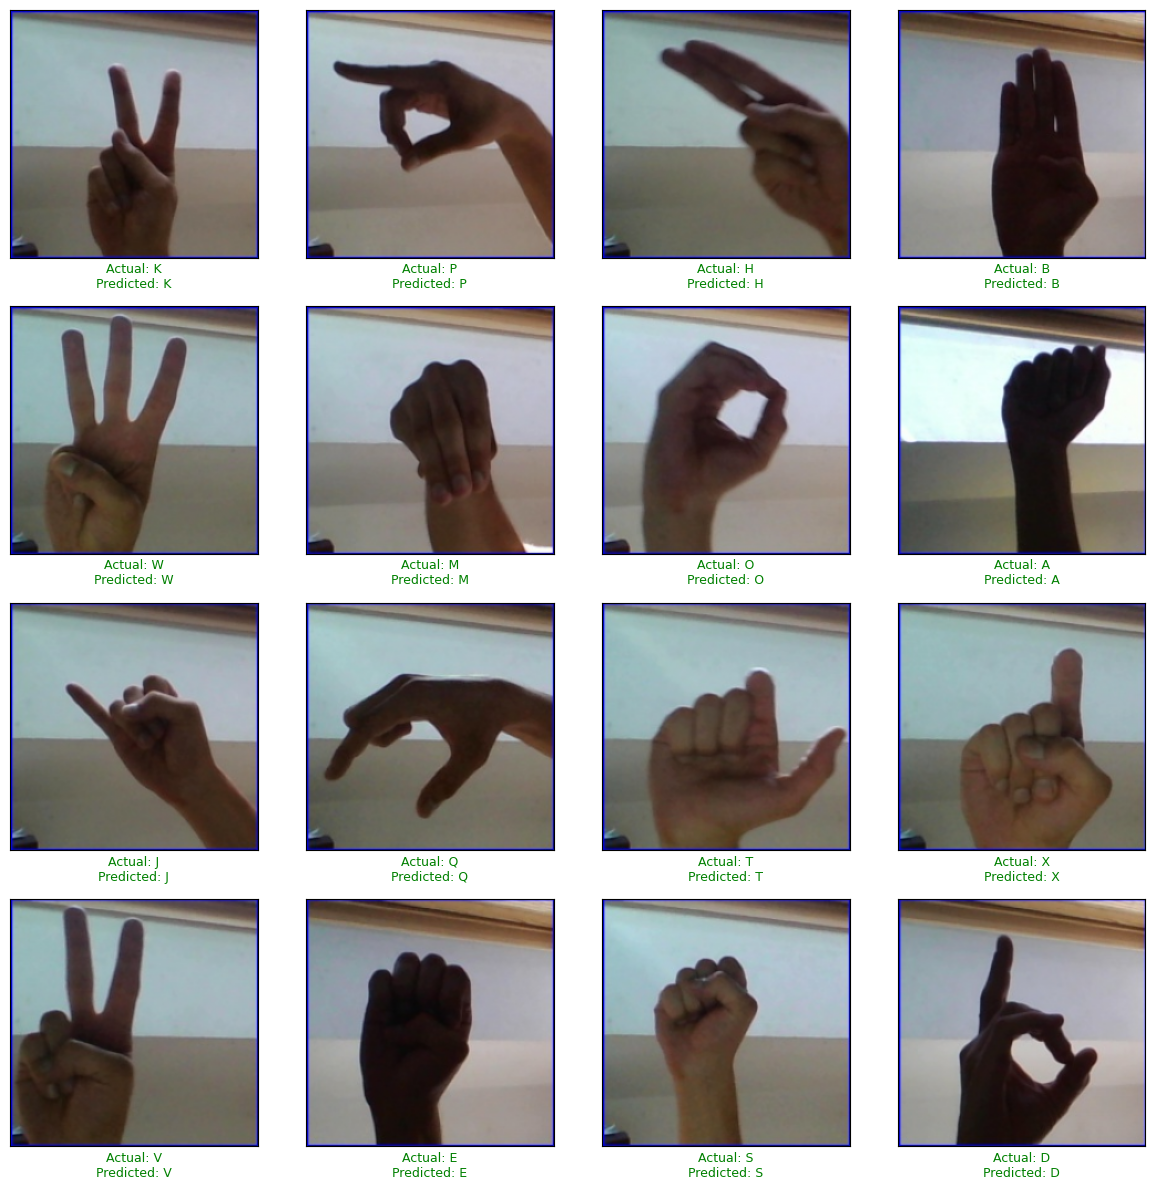

In [30]:
index_to_class = {v: k for k, v in class_to_index.items()}


test_labels_raw = test_labels


predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


n_images = min(16, len(test_images))
plt.figure(figsize=(12, 12))
for i, img in enumerate(tqdm(test_images[:n_images])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    actual_class = index_to_class[test_labels_raw[i]]
    predicted_class = index_to_class[predicted_labels[i]]

    color = 'green' if actual_class == predicted_class else 'red'
    plt.xlabel(f'Actual: {actual_class}\nPredicted: {predicted_class}', color=color, fontsize=9)

plt.tight_layout()
plt.show()

# VGG16 Model
**VGG16 is a Convolutional Neural Network (CNN) model developed by the Visual Geometry Group (VGG) at Oxford University in 2014. It is known for its simplicity and depth, and has been widely used in computer vision tasks such as image classification and object recognition.**

In [31]:
trained_VGG16_layers = VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
for layer in trained_VGG16_layers.layers:
    layer.trainable = False

In [33]:
VGG16_model = keras.models.Sequential([
    trained_VGG16_layers,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(len(cnn_val_generator.class_indices), activation='softmax')
]) 

In [34]:
VGG16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,946,333 (68.46 MB)

 Trainable params: 3,231,645 (12.33 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='VGG16_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [36]:
VGG16_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [37]:
VGG16_history = VGG16_model.fit(
        cnn_train_generator,
        epochs = 5,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6661 - loss: 1.2325 - precision: 0.9064 - recall: 0.5250
Epoch 1: val_loss improved from inf to 0.04576, saving model to VGG16_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 302s 497ms/step - accuracy: 0.6665 - loss: 1.2312 - precision: 0.9065 - recall: 0.5255 - val_accuracy: 0.9918 - val_loss: 0.0458 - val_precision: 0.9946 - val_recall: 0.9864
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9882 - loss: 0.0474 - precision: 0.9917 - recall: 0.9844
Epoch 2: val_loss improved from 0.04576 to 0.02555, saving model to VGG16_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 232s 421ms/step - accuracy: 0.9882 - loss: 0.0474 - precision: 0.9917 - recall: 0.9844 - val_accuracy: 0.9940 - val_loss: 0.0255 - val_precision: 0.9954 - val_recall: 0.9917
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9943 - loss: 0.0227 - precision: 0.9955 - recall: 0.9931
Epoch 3: val_loss improved from 0.02555 to 0

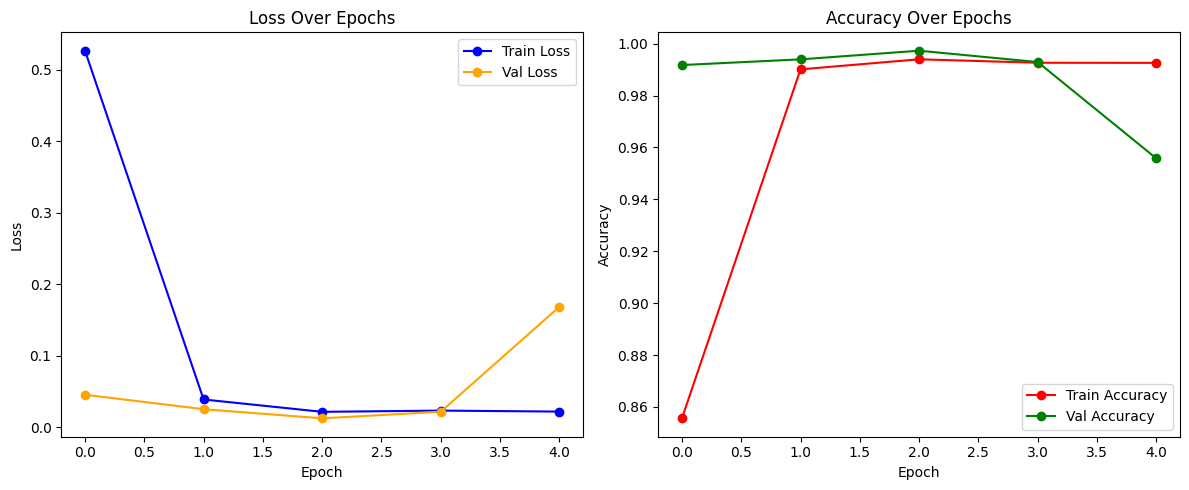

In [38]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG16_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG16_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluating and Predicting with the Best Model VGG16

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 6.0681e-04 - precision: 1.0000 - recall: 1.0000
Test Loss: 0.0006
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1

<Figure size 1000x800 with 0 Axes>

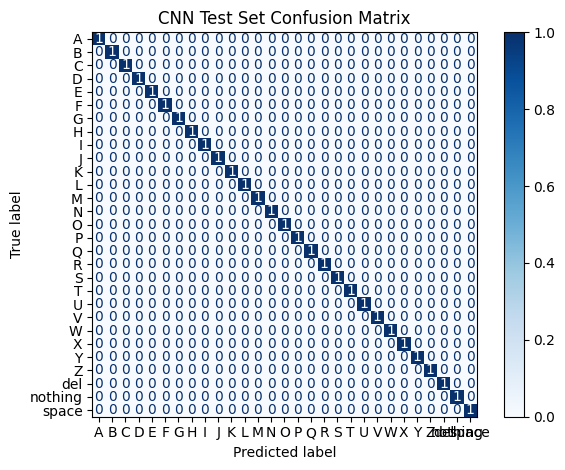

In [39]:
VGG16_model.save('VGG16_best_model.keras')
best_model=load_model('VGG16_best_model.keras')
# Evaluate the best model on test data
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    test_images, 
    test_labels_one_hot
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

#  Generate predictions with the best model
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels  # Use test_labels directly (class indices)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#  Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_index.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Test Set Confusion Matrix')
plt.tight_layout()


#  Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=list(class_to_index.keys()))
print("\nClassification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/16 [00:00<?, ?it/s]

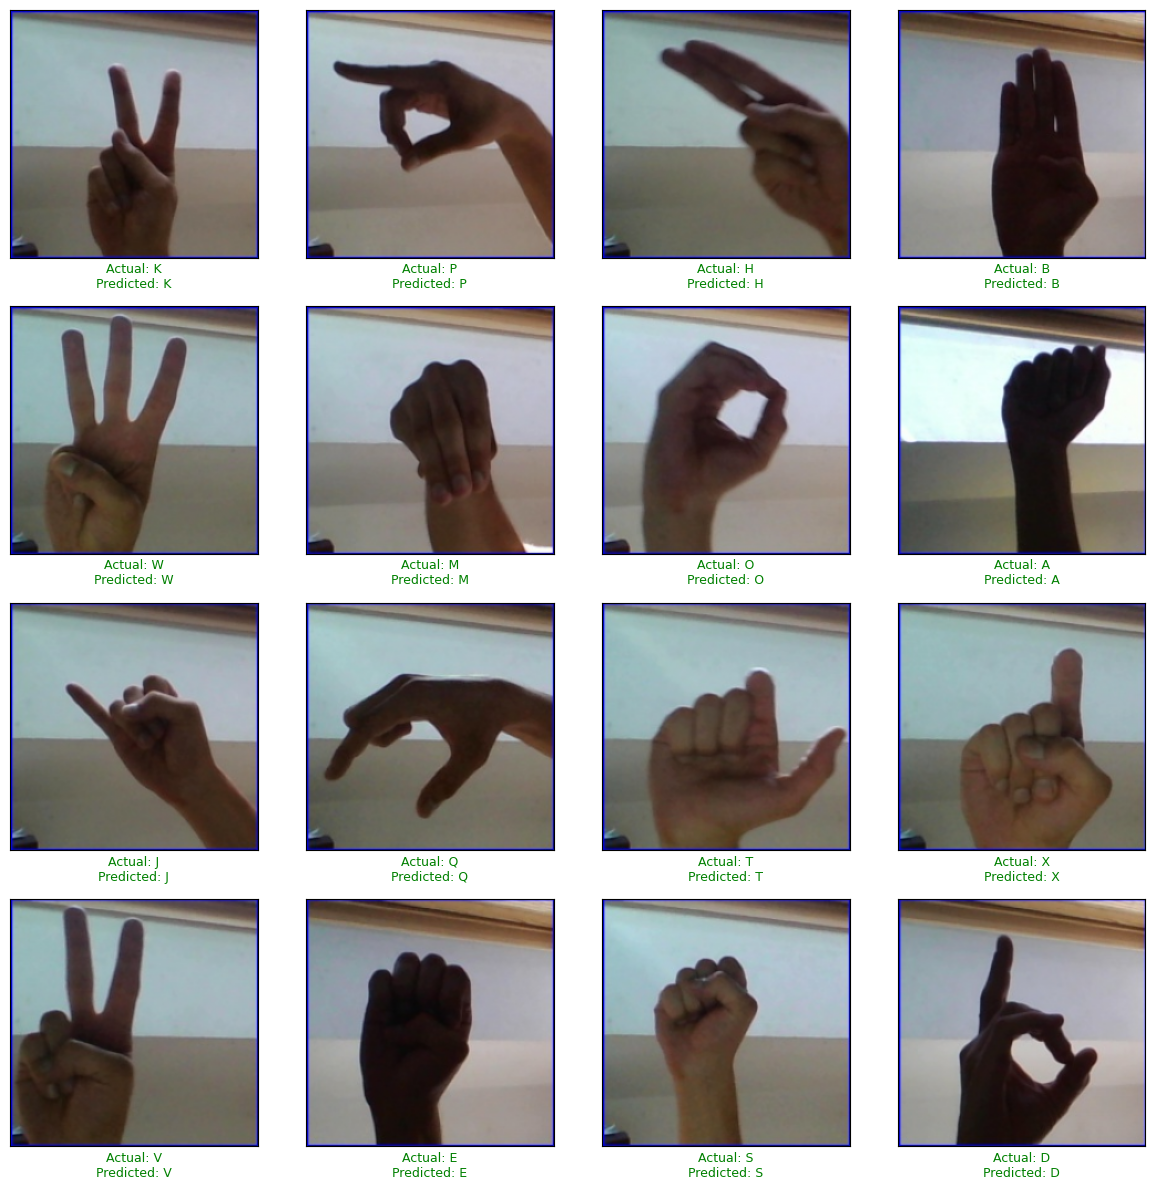

In [40]:

index_to_class = {v: k for k, v in class_to_index.items()}


test_labels_raw = test_labels


predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


n_images = min(16, len(test_images))
plt.figure(figsize=(12, 12))
for i, img in enumerate(tqdm(test_images[:n_images])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    actual_class = index_to_class[test_labels_raw[i]]
    predicted_class = index_to_class[predicted_labels[i]]

    color = 'green' if actual_class == predicted_class else 'red'
    plt.xlabel(f'Actual: {actual_class}\nPredicted: {predicted_class}', color=color, fontsize=9)

plt.tight_layout()
plt.show()

# ResNet50V2 Model
**ResNet50V2 (Residual Networks, version 2) is a deep convolutional neural network architecture that is part of the ResNet family developed by Microsoft Research. ResNet is known for its use of residual connections, which allow for training very deep networks without the vanishing gradient problem.**

In [41]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False


In [43]:
ResNet_model = keras.models.Sequential([
    trained_ResNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(cnn_val_generator.class_indices), activation='softmax')
])

In [44]:
ResNet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,830,813 (90.91 MB)

 Trainable params: 266,013 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [45]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='ResNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [46]:
ResNet_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [47]:
ResNet_history = ResNet_model.fit(
        cnn_train_generator,
        epochs = 5,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8130 - loss: 0.7561 - precision: 0.9587 - recall: 0.6911
Epoch 1: val_loss improved from inf to 0.06129, saving model to ResNet_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 264s 447ms/step - accuracy: 0.8132 - loss: 0.7553 - precision: 0.9587 - recall: 0.6915 - val_accuracy: 0.9861 - val_loss: 0.0613 - val_precision: 0.9908 - val_recall: 0.9814
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9919 - loss: 0.0433 - precision: 0.9940 - recall: 0.9877
Epoch 2: val_loss improved from 0.06129 to 0.03367, saving model to ResNet_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 308s 562ms/step - accuracy: 0.9919 - loss: 0.0433 - precision: 0.9940 - recall: 0.9877 - val_accuracy: 0.9917 - val_loss: 0.0337 - val_precision: 0.9942 - val_recall: 0.9892
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9965 - loss: 0.0189 - precision: 0.9973 - recall: 0.9958
Epoch 3: val_loss improved from 0.03367 to

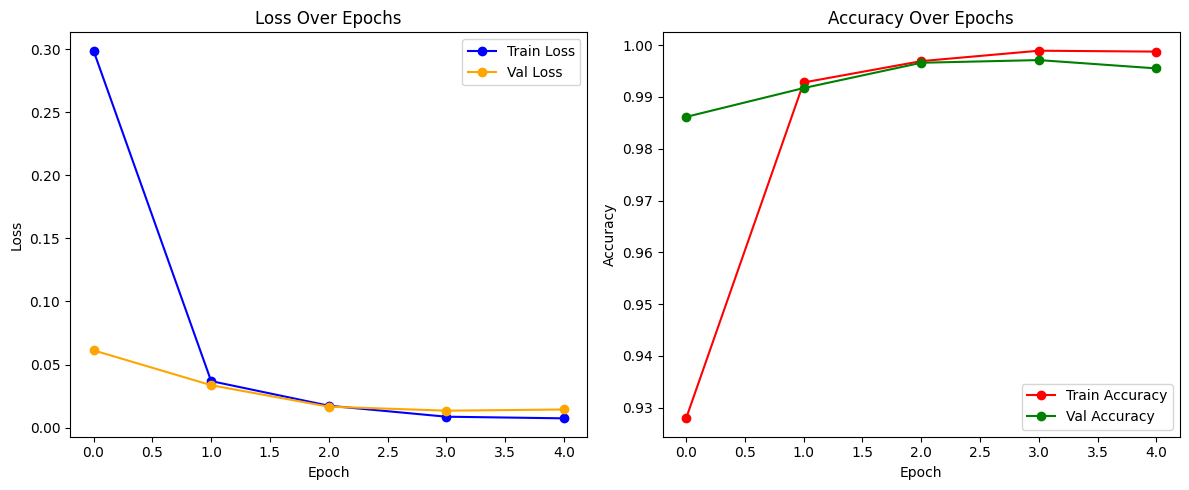

In [48]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluating and Predicting with the Best Model ResNet50V2

In [49]:
ResNet_model.save('ResNet_best_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 1.0000 - loss: 0.0106 - precision: 1.0000 - recall: 1.0000
Test Loss: 0.0106
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00    

<Figure size 1000x800 with 0 Axes>

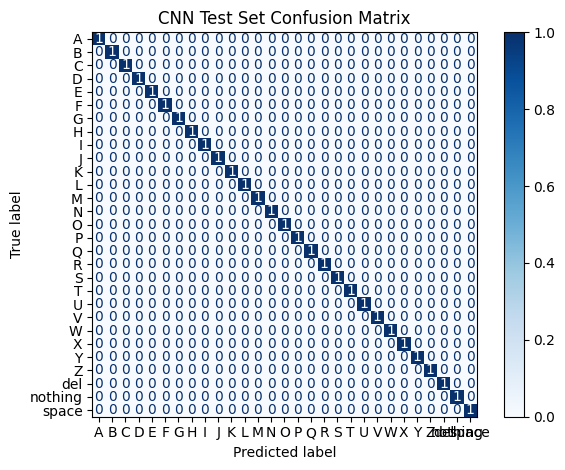

In [50]:

best_model=load_model('ResNet_best_model.keras')
# Evaluate the best model on test data
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    test_images, 
    test_labels_one_hot
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions with the best model
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels  # Use test_labels directly (class indices)

#  Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#  Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_index.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Test Set Confusion Matrix')
plt.tight_layout()


#  Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=list(class_to_index.keys()))
print("\nClassification Report:")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/16 [00:00<?, ?it/s]

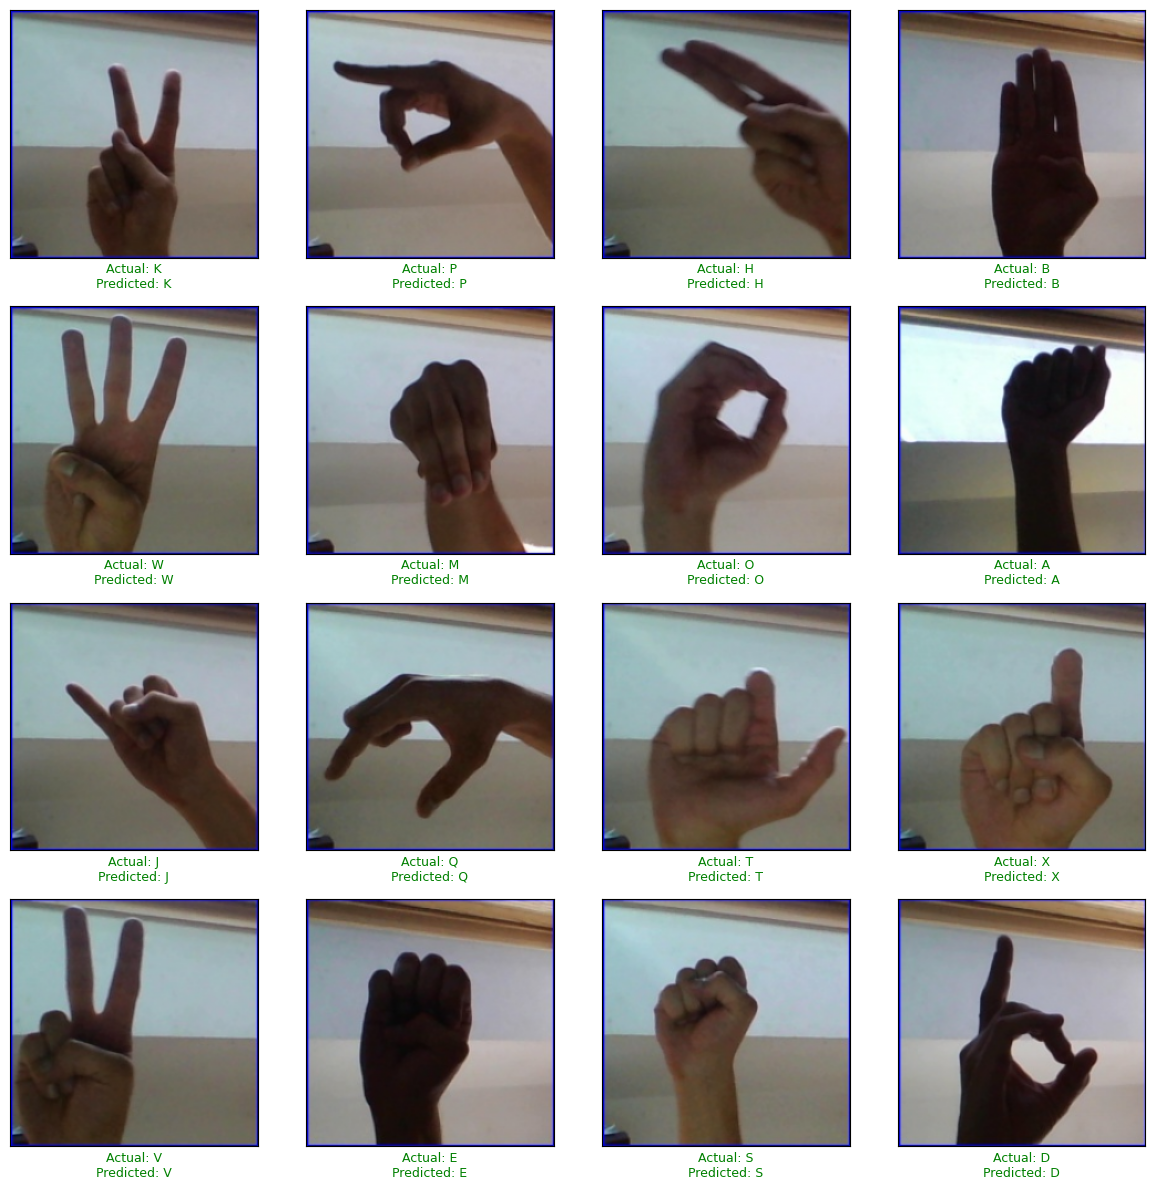

In [51]:
index_to_class = {v: k for k, v in class_to_index.items()}


test_labels_raw = test_labels


predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


n_images = min(16, len(test_images))
plt.figure(figsize=(12, 12))
for i, img in enumerate(tqdm(test_images[:n_images])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    actual_class = index_to_class[test_labels_raw[i]]
    predicted_class = index_to_class[predicted_labels[i]]

    color = 'green' if actual_class == predicted_class else 'red'
    plt.xlabel(f'Actual: {actual_class}\nPredicted: {predicted_class}', color=color, fontsize=9)

plt.tight_layout()
plt.show()

# MobileNetV2 Model
**MobileNetV2 is a deep learning model optimized for mobile and embedded devices. It is an evolution of the MobileNetV1 model, designed to be highly efficient and lightweight, while still maintaining good accuracy for image classification tasks. It was developed by Google and uses a novel architecture that makes it well-suited for applications on devices with limited computational resources.**

In [52]:
trained_MobileNet_layers = MobileNetV2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [53]:
for layer in trained_MobileNet_layers.layers:
    layer.trainable = False


In [54]:
MobileNet_model = keras.models.Sequential([
    trained_MobileNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
     keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(cnn_val_generator.class_indices), activation='softmax')
]) 

In [55]:
MobileNet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,081,821 (11.76 MB)

 Trainable params: 823,837 (3.14 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [56]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='MobileNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [57]:
MobileNet_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [58]:
MobileNet_history = MobileNet_model.fit(
        cnn_train_generator,
        epochs = 5,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7445 - loss: 0.8774 - precision: 0.9086 - recall: 0.6550
Epoch 1: val_loss improved from inf to 0.04506, saving model to MobileNet_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 261s 450ms/step - accuracy: 0.7448 - loss: 0.8765 - precision: 0.9087 - recall: 0.6553 - val_accuracy: 0.9860 - val_loss: 0.0451 - val_precision: 0.9888 - val_recall: 0.9834
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9782 - loss: 0.0675 - precision: 0.9817 - recall: 0.9745
Epoch 2: val_loss improved from 0.04506 to 0.02967, saving model to MobileNet_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 241s 438ms/step - accuracy: 0.9782 - loss: 0.0675 - precision: 0.9817 - recall: 0.9745 - val_accuracy: 0.9913 - val_loss: 0.0297 - val_precision: 0.9924 - val_recall: 0.9903
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9855 - loss: 0.0434 - precision: 0.9877 - recall: 0.9837
Epoch 3: val_loss did not improve fr

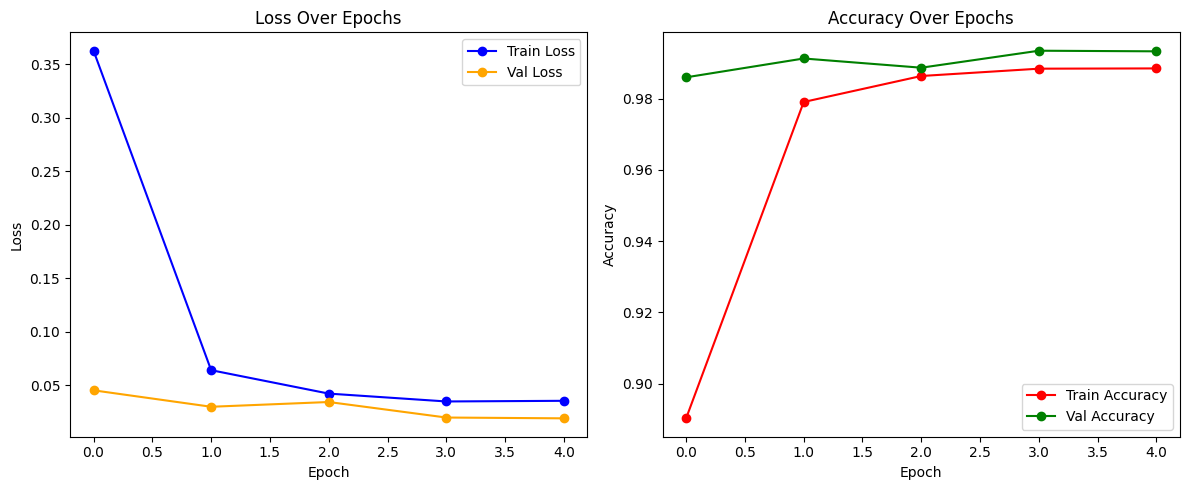

In [59]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(MobileNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(MobileNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(MobileNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(MobileNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluating and Predicting with the Best Model MobileNetV2

In [60]:
MobileNet_model.save('MobileNet_best_model.keras')

In [61]:
#converter = tf.lite.TFLiteConverter.from_keras_model(MobileNet_best_model)
#tflite_model = converter.convert()

#with open("model.tflite", 'wb') as f:
#    f.write(tflite_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9655 - loss: 0.1397 - precision: 0.9655 - recall: 0.9655
Test Loss: 0.1397
Test Accuracy: 0.9655
Test Precision: 0.9655
Test Recall: 0.9655
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00    

<Figure size 1000x800 with 0 Axes>

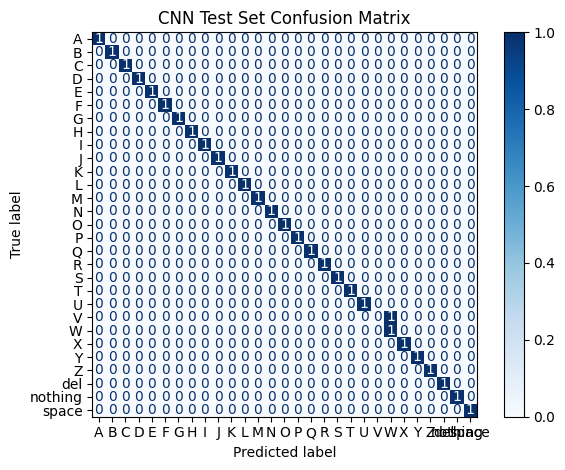

In [62]:


best_model=load_model('MobileNet_best_model.keras')
# Evaluate the best model on test data
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    test_images, 
    test_labels_one_hot
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions with the best model
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels  # Use test_labels directly (class indices)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_index.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Test Set Confusion Matrix')
plt.tight_layout()


# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=list(class_to_index.keys()))
print("\nClassification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/16 [00:00<?, ?it/s]

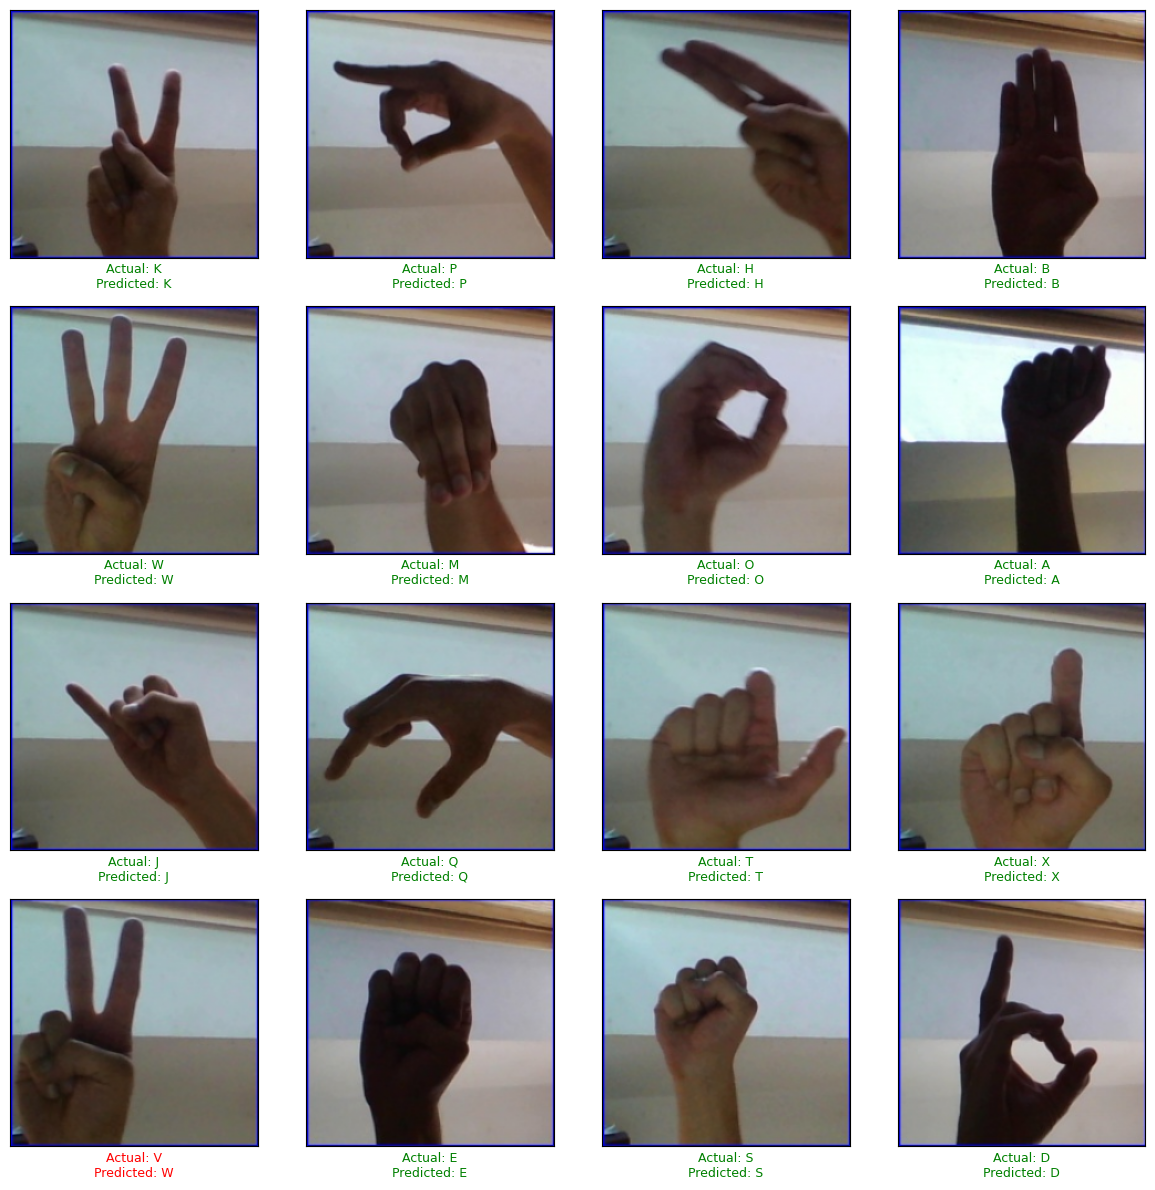

In [63]:

index_to_class = {v: k for k, v in class_to_index.items()}


test_labels_raw = test_labels


predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


n_images = min(16, len(test_images))
plt.figure(figsize=(12, 12))
for i, img in enumerate(tqdm(test_images[:n_images])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    actual_class = index_to_class[test_labels_raw[i]]
    predicted_class = index_to_class[predicted_labels[i]]

    color = 'green' if actual_class == predicted_class else 'red'
    plt.xlabel(f'Actual: {actual_class}\nPredicted: {predicted_class}', color=color, fontsize=9)

plt.tight_layout()
plt.show()

# DenseNet201 Model
**DenseNet201 is a deep convolutional neural network that is part of the DenseNet (Densely Connected Convolutional Networks) family. DenseNet201 is a deeper version, consisting of 201 layers, and is known for its high accuracy and efficient parameter usage.**



In [64]:
from tensorflow.keras.applications import DenseNet201

In [65]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [66]:
DenseNet_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(cnn_val_generator.class_indices), activation='softmax')
])

In [67]:
DenseNet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         245,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,571,613 (70.85 MB)

 Trainable params: 249,629 (975.11 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [68]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='DenseNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [69]:
DenseNet_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

In [70]:
DenseNet_history = DenseNet_model.fit(
    cnn_train_generator,
    epochs=5,
    validation_data=cnn_val_generator,
    callbacks=callbacks
)

Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7829 - loss: 0.9330 - precision: 0.9673 - recall: 0.6085
Epoch 1: val_loss improved from inf to 0.07587, saving model to DenseNet_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 379s 586ms/step - accuracy: 0.7831 - loss: 0.9320 - precision: 0.9673 - recall: 0.6089 - val_accuracy: 0.9880 - val_loss: 0.0759 - val_precision: 0.9938 - val_recall: 0.9780
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9919 - loss: 0.0562 - precision: 0.9954 - recall: 0.9854
Epoch 2: val_loss improved from 0.07587 to 0.02988, saving model to DenseNet_best_model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 243s 441ms/step - accuracy: 0.9919 - loss: 0.0562 - precision: 0.9954 - recall: 0.9854 - val_accuracy: 0.9961 - val_loss: 0.0299 - val_precision: 0.9975 - val_recall: 0.9929
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9967 - loss: 0.0251 - precision: 0.9979 - recall: 0.9945
Epoch 3: val_loss improved from 0.0298

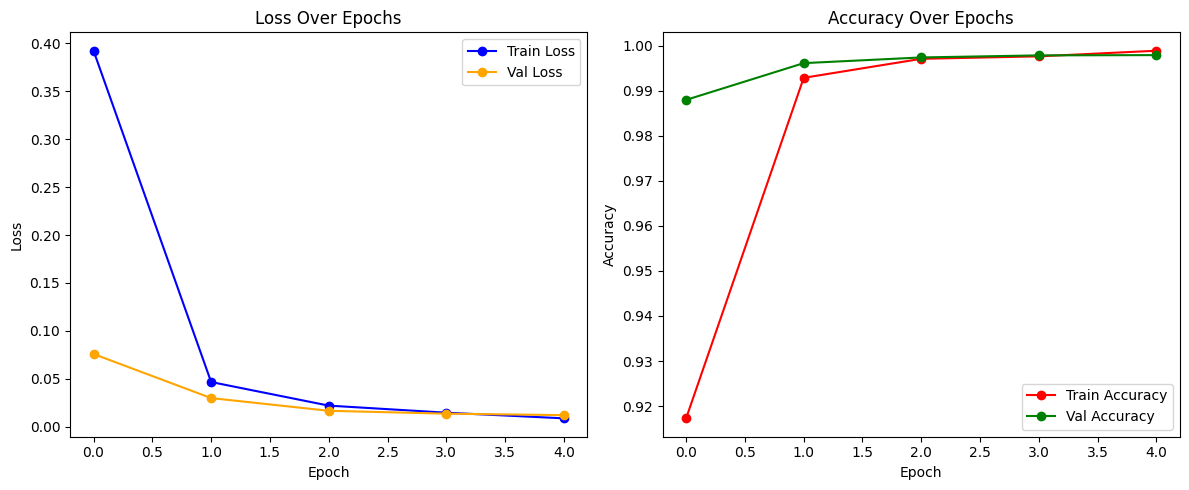

In [71]:
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(DenseNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(DenseNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(DenseNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(DenseNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluating and Predicting with the Best Model DenseNet201

In [72]:
DenseNet_model.save('DenseNet_best_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 1.0000 - loss: 0.0023 - precision: 1.0000 - recall: 1.0000
Test Loss: 0.0023
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00

<Figure size 1000x800 with 0 Axes>

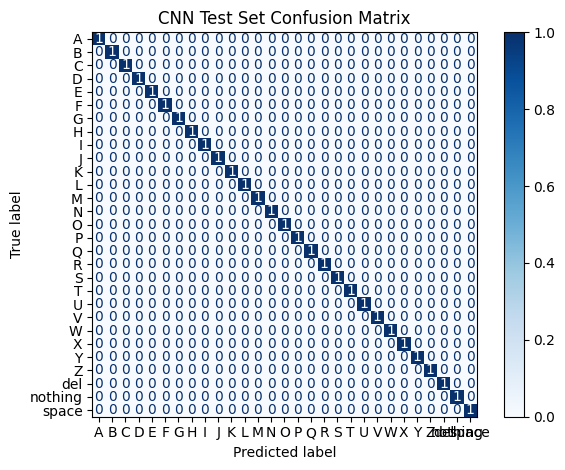

In [73]:

best_model=load_model('DenseNet_best_model.keras')
# Evaluate the best model on test data
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    test_images, 
    test_labels_one_hot
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Step 8: Generate predictions with the best model
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels  # Use test_labels directly (class indices)

# Step 9: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 10: Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_index.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Test Set Confusion Matrix')
plt.tight_layout()


# Step 11: Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=list(class_to_index.keys()))
print("\nClassification Report:")
print(report)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/16 [00:00<?, ?it/s]

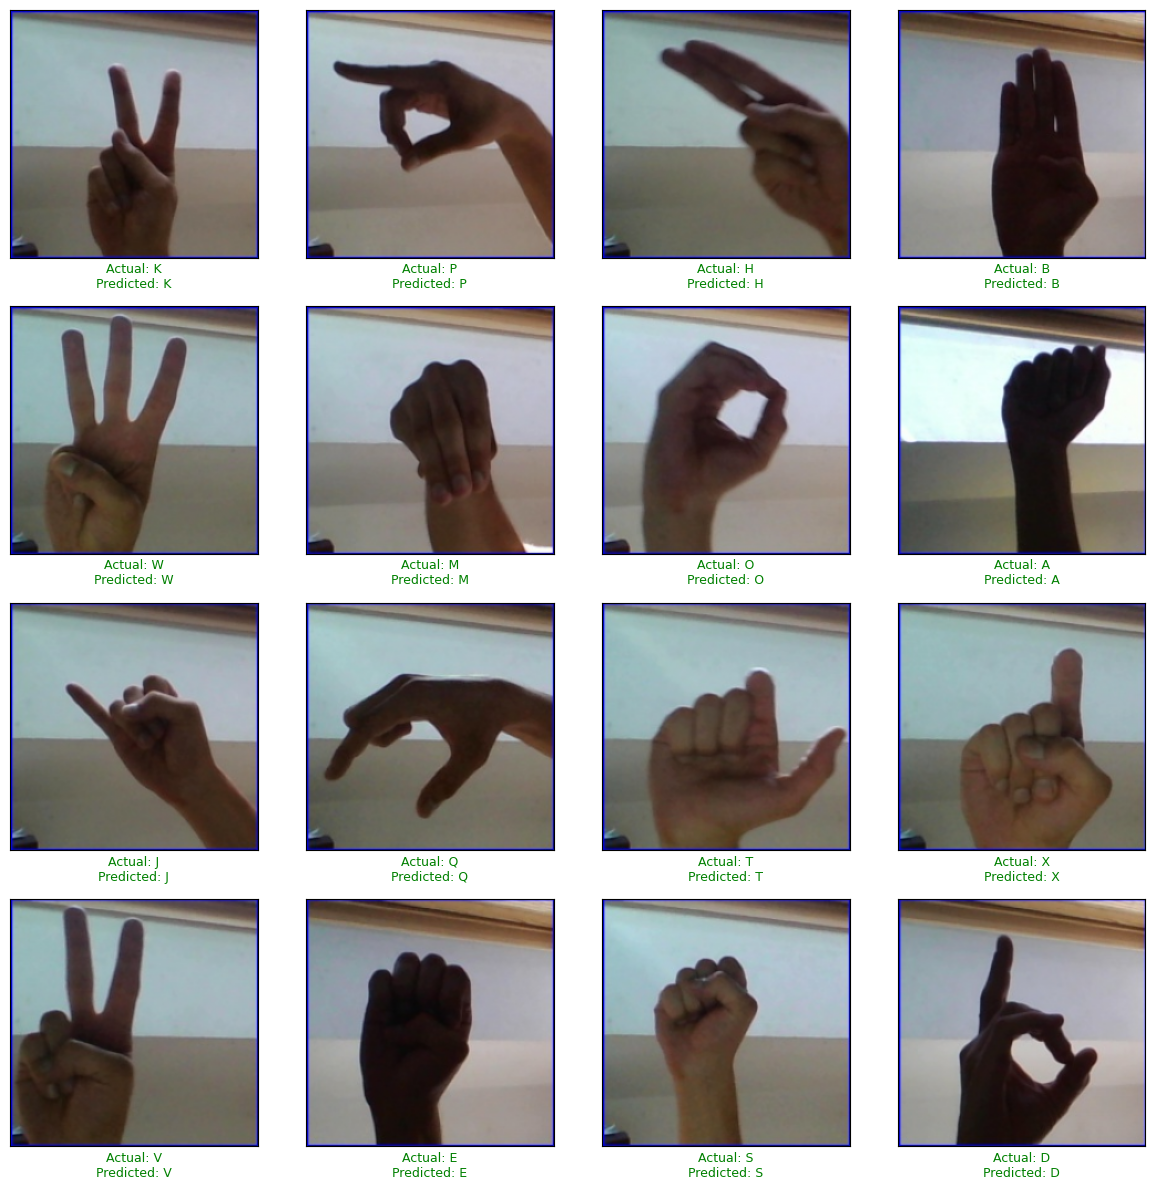

In [74]:
index_to_class = {v: k for k, v in class_to_index.items()}


test_labels_raw = test_labels


predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


n_images = min(16, len(test_images))
plt.figure(figsize=(12, 12))
for i, img in enumerate(tqdm(test_images[:n_images])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    actual_class = index_to_class[test_labels_raw[i]]
    predicted_class = index_to_class[predicted_labels[i]]

    color = 'green' if actual_class == predicted_class else 'red'
    plt.xlabel(f'Actual: {actual_class}\nPredicted: {predicted_class}', color=color, fontsize=9)

plt.tight_layout()
plt.show()

# Compare Between Models

In [75]:
history = {
    "CNN": {"accuracy": cnn_history.history['accuracy'],"val_accuracy": cnn_history.history['val_accuracy'] ,"loss": cnn_history.history['loss'],"val_loss": cnn_history.history['val_loss']},
    "MobileNetV2": {"accuracy": MobileNet_history.history['accuracy'],"val_accuracy": MobileNet_history.history['val_accuracy'], "loss": MobileNet_history.history['loss'],"val_loss": MobileNet_history.history['val_loss']},
    "VGG16": {"accuracy": VGG16_history.history['accuracy'],"val_accuracy": VGG16_history.history['val_accuracy'], "loss": VGG16_history.history['loss'],"val_loss": VGG16_history.history['val_loss']},
    "DenseNet": {"accuracy": DenseNet_history.history['accuracy'],"val_accuracy": DenseNet_history.history['val_accuracy'], "loss": DenseNet_history.history['loss'],"val_loss": DenseNet_history.history['val_loss']},
    "ResNet50V2": {"accuracy": ResNet_history.history['accuracy'],"val_accuracy": ResNet_history.history['val_accuracy'], "loss": ResNet_history.history['loss'],"val_loss": ResNet_history.history['val_loss']}
}

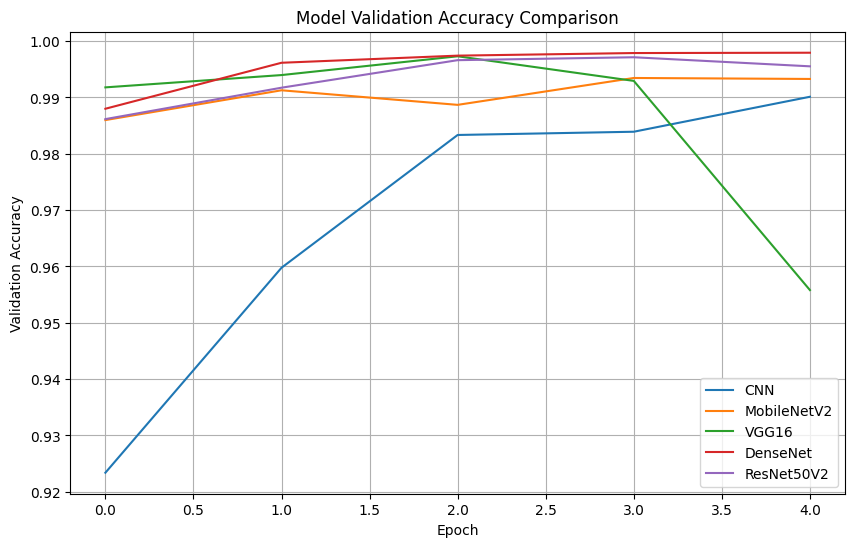

In [76]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_accuracy'], label=model)
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


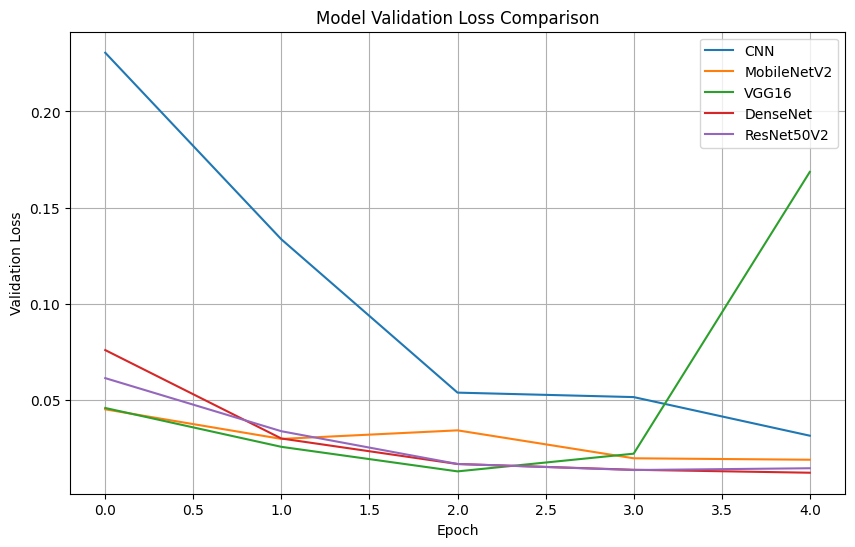

In [77]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_loss'], label=model)
plt.title('Model Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


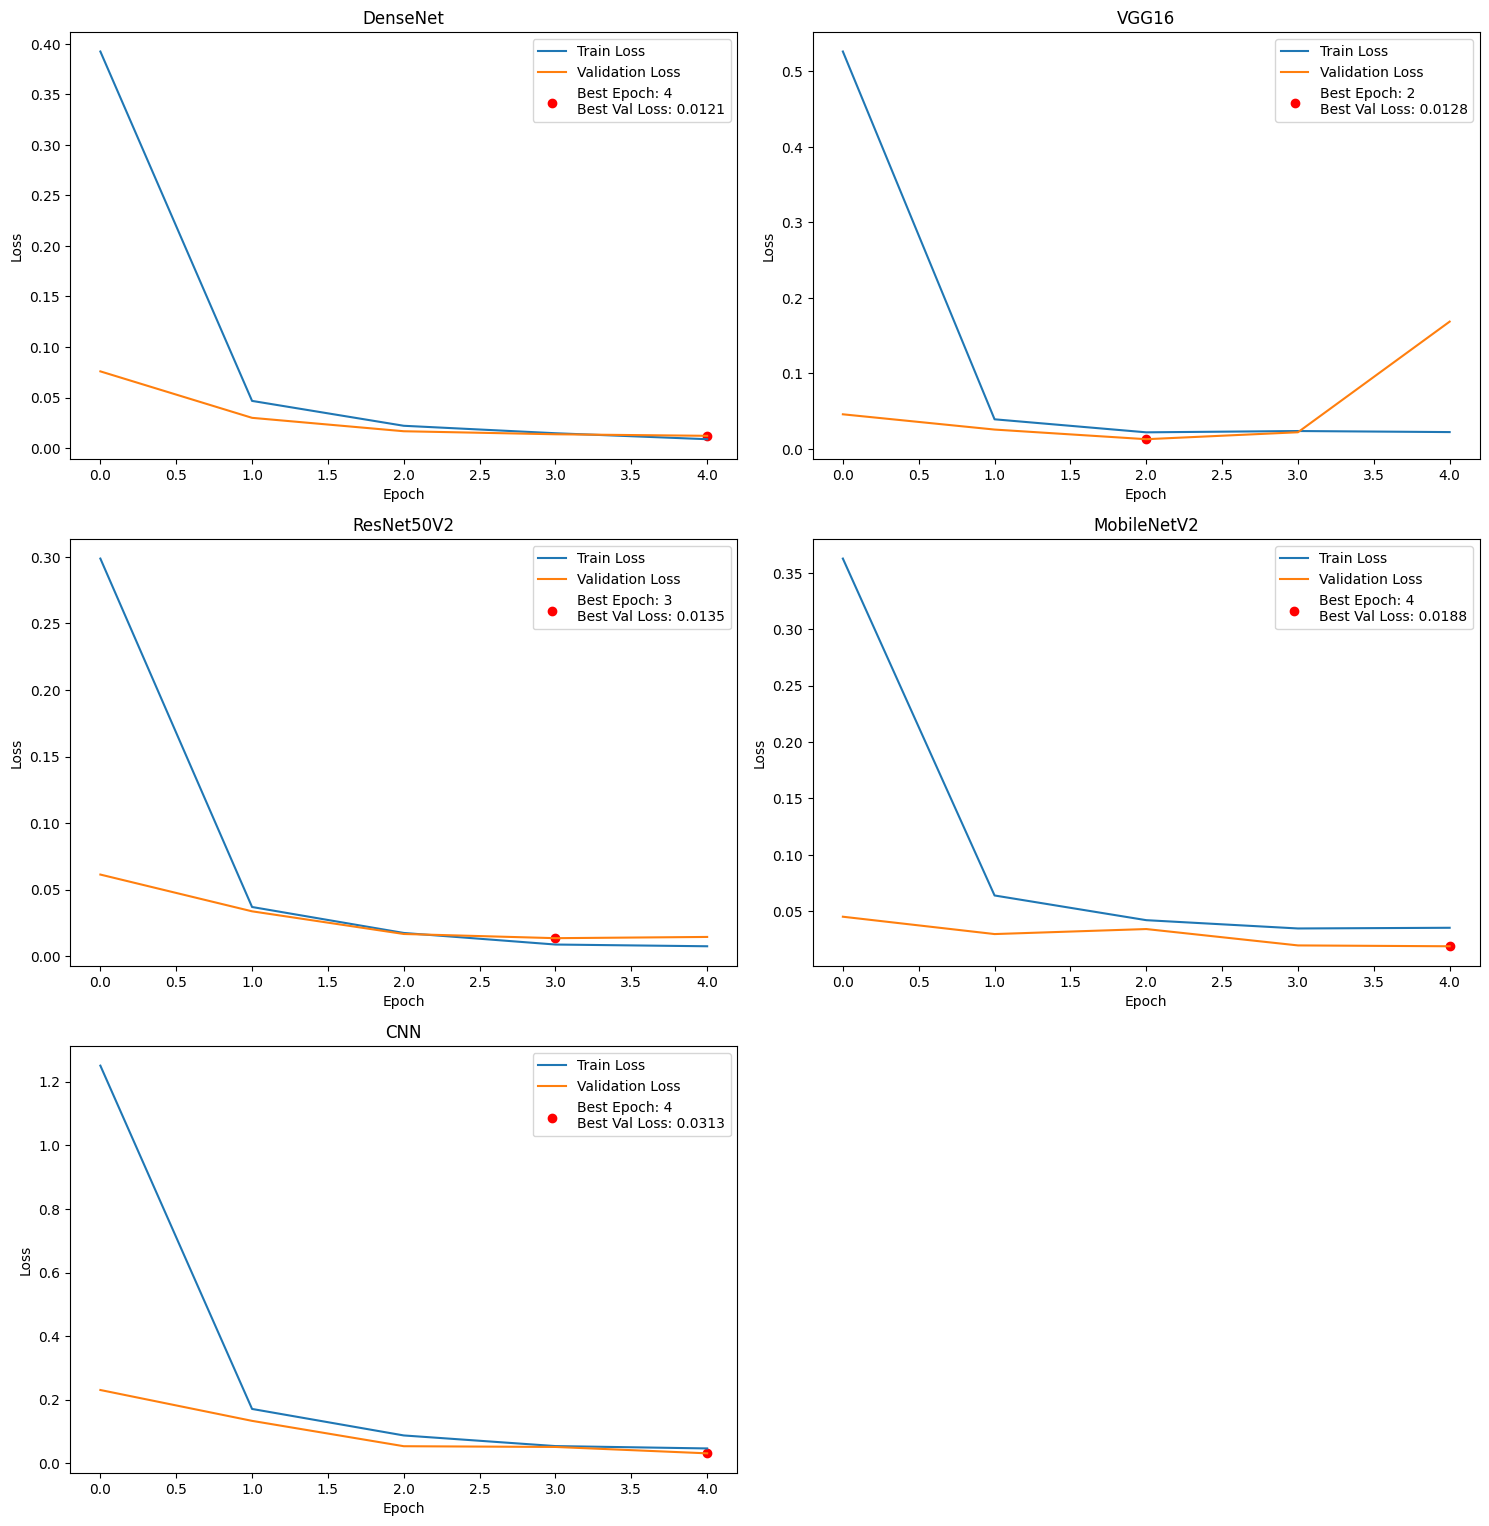

In [78]:
plt.figure(figsize=(15, 20))

# Sort models by least validation loss
sorted_models = sorted(history.items(), key=lambda x: min(x[1]['val_loss']))

# Plot each model based on sorted order of least val_loss
for i, (model_name, model_history) in enumerate(sorted_models, 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['loss'], label='Train Loss')
    plt.plot(model_history['val_loss'], label='Validation Loss')

    # Find the best epoch based on least val_loss
    min_val_loss_epoch = model_history['val_loss'].index(min(model_history['val_loss']))
    min_val_loss = min(model_history['val_loss'])

    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Best Epoch: {min_val_loss_epoch}\nBest Val Loss: {min_val_loss:.4f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


In [79]:
best_CNN = load_model('/kaggle/working/CNN_best_model.keras')
best_MobileNetV2 = load_model('/kaggle/working/MobileNet_best_model.keras')
best_VGG16 = load_model('/kaggle/working/VGG16_best_model.keras')
best_DenseNet = load_model('/kaggle/working/DenseNet_best_model.keras')
best_ResNet50 = load_model('/kaggle/working/ResNet_best_model.keras')

In [80]:
models = ['Best CNN','Best MobileNetV2','Best VGG16','Best DenseNet','Best ResNest50']
best_train_accuracy= [
                        cnn_history.history['accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        MobileNet_history.history['accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
                        VGG16_history.history['accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
                        DenseNet_history.history['accuracy'][np.argmax(DenseNet_history.history['val_accuracy'])],
                        ResNet_history.history['accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]
best_val_accuracy= [
                        cnn_history.history['val_accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        MobileNet_history.history['val_accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
                        VGG16_history.history['val_accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
                        DenseNet_history.history['val_accuracy'][np.argmax(DenseNet_history.history['val_accuracy'])],
                        ResNet_history.history['val_accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]

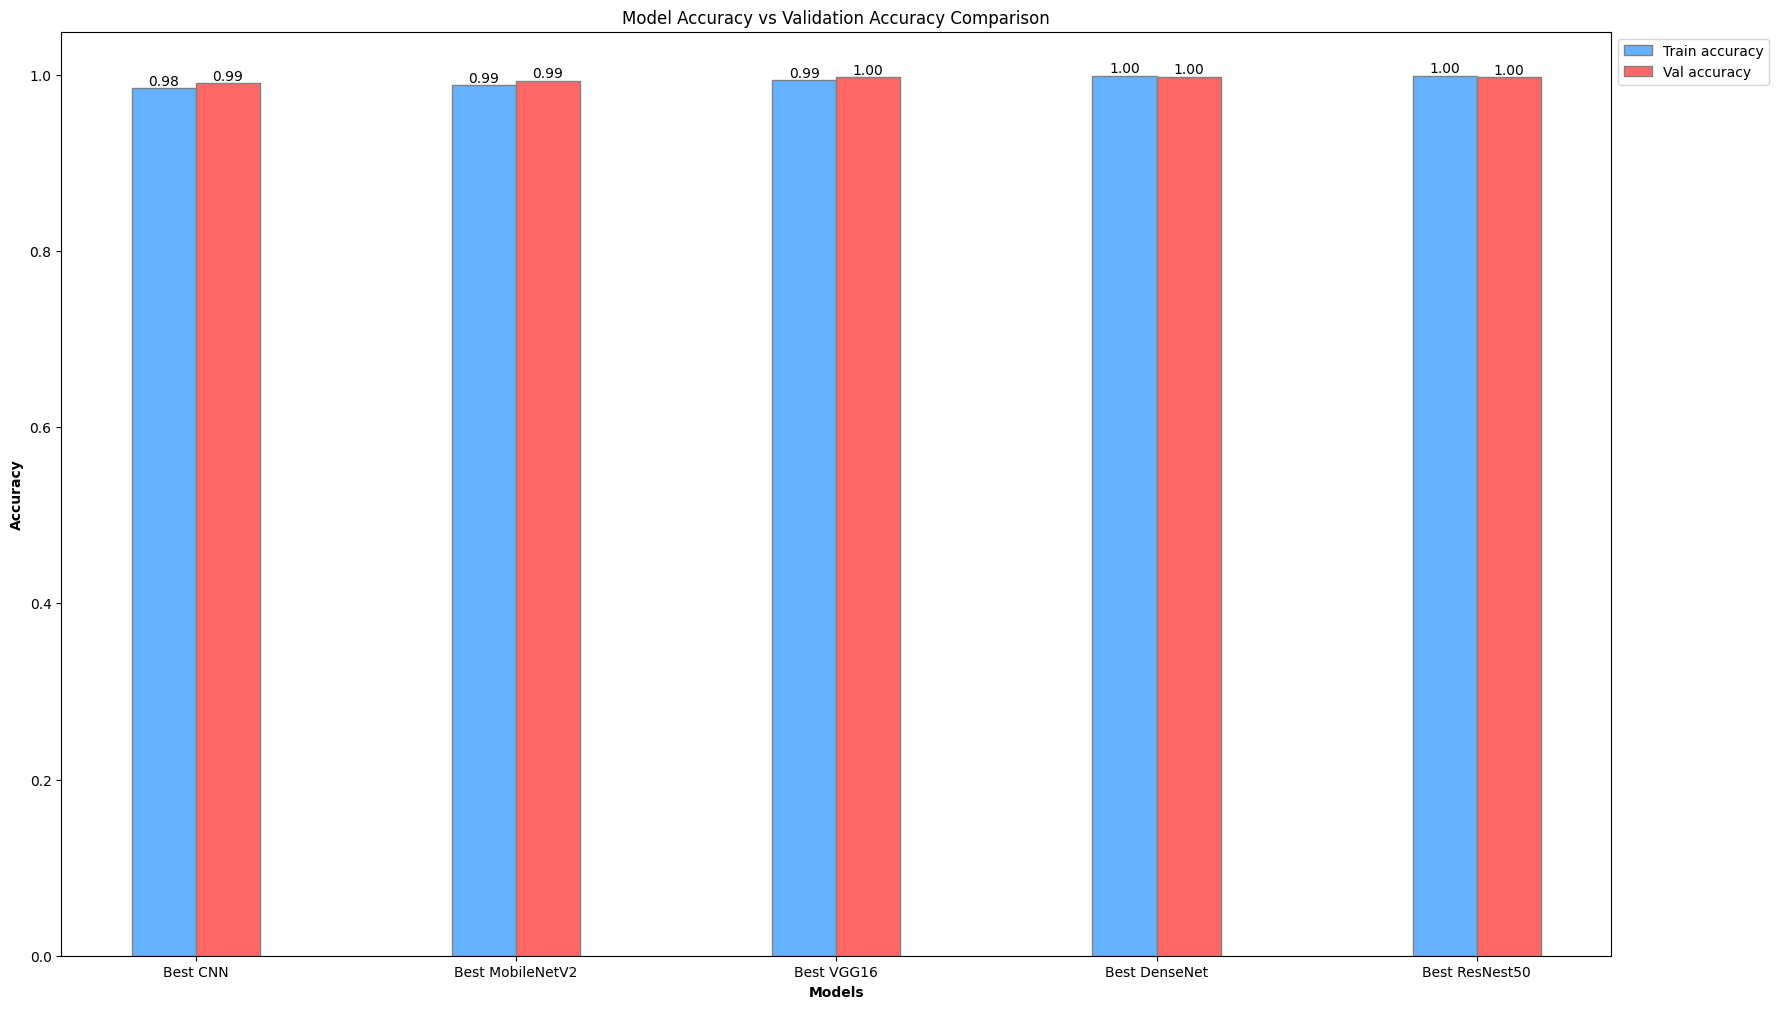

In [81]:
barWidth = 0.20

r1 = np.arange(len(best_train_accuracy))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 12))
bars1 = plt.bar(r1, best_train_accuracy, color='#66B2FF', width=barWidth, edgecolor='grey', label='Train accuracy')
bars2 = plt.bar(r2, best_val_accuracy, color='#FF6666', width=barWidth, edgecolor='grey', label='Val accuracy')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(best_train_accuracy))], models)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Model Accuracy vs Validation Accuracy Comparison')
plt.show()